# CIFAR-10 dataset using DCGANs

Deep Convolutional Generative Adversarial Network

useful articles to get started


- https://developers.google.com/machine-learning/gan   #Google devolper tutorials
- https://www.tensorflow.org/tutorials/generative/dcgan     #TF tutorials >>> train from scratch
- https://www.tensorflow.org/hub/tutorials/tf_hub_generative_image_module #TF  hub tutorials  >> uses Pretrained models
- https://towardsdatascience.com/pix2pix-869c17900998




---




**Problems while trainig GANs**
- https://developers.google.com/machine-learning/gan/problems
- https://www.quora.com/What-does-it-mean-if-all-produced-images-of-a-GAN-look-the-same



---


**My GAN notebooks**
- [intro_to_DCGANS](https://colab.research.google.com/drive/1e4mo3yyg1isOGy6fL0ePJ1qNjSVJEXke#scrollTo=ZvbJIqxpHMnN)
- [Pix2Pix](https://colab.research.google.com/drive/1K6SVVMpvTKShjRrFuGhg321erc2-B-lw#scrollTo=sRHEY2l5rT_q)
- [Cycle GANs](https://colab.research.google.com/drive/1RbgL9qMDbPxCE2nQyNniww6zzaziri15)


In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.3.0'

In [3]:
# To generate GIFs
!pip install imageio
#!pip install git+https://github.com/tensorflow/docs

In [2]:
import glob
import imageio
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape

import time
from IPython import display

###### Load and prepare the dataset

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
print(type(train_images))
print(train_images.shape[0] , train_images.shape[1],train_images.shape[2])

11493376/11490434 [==============================] - 0s 0us/step
<class 'numpy.ndarray'>
60000 28 28


In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

#### CIFAR10 dataset

In [127]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()
print(type(train_images))
print(train_images.shape[0] , train_images.shape[1],train_images.shape[2], train_images.shape[3])

<class 'numpy.ndarray'>
50000 32 32 3


In [128]:
new_data = []

for i in range(len(train_images)):
  #data = Image.fromarray(train_images[i,:,:])    #RGB mode
  data = Image.fromarray(train_images[i,:,:]).convert('L')  # B$W mode
  #data.show
  new_data.append(np.asarray(data.resize((28,28))))

train_images = np.asarray(new_data)
print(type(train_images))
#print(train_images.shape[0] , train_images.shape[1],train_images.shape[2] , train_images.shape[3])  # for RGB mode
print(train_images.shape[0] , train_images.shape[1],train_images.shape[2] )   #for B$W moide

<class 'numpy.ndarray'>
50000 28 28


In [ ]:
#confirm b$w mode

print(train_images.shape[3] )   #genertes error     

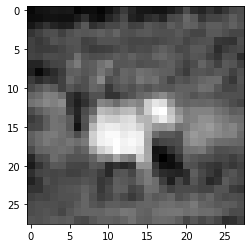

In [129]:
from matplotlib import pyplot as plt
my_image = train_images[3,:,:]
plt.imshow(my_image, cmap='gray')

**Normalize the images to [-1, 1]** 


Why input images are normalized to [-1, 1] at the very beginning?

- https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/550
- in depth answers - https://sthalles.github.io/advanced_gans/
- https://stats.stackexchange.com/questions/360066/does-it-make-sense-to-preprocess-normalise-or-standardise-this-data-for-gan

In [130]:
#  b$w
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')    #to add 1 to the dimension
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]          #worked(visually) for black and white, not so much for colored images

In [ ]:
#if coloured
#train_images = (train_images - 255) / 255    #for coloured images >>> 
#  But 255 alos does the same??  Bad idea??? >>> centre it around 0 so noramlaize for -1, 1


fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)

for i in range(0,25):
  my_image = train_images[i,:,:]
  plt.subplot(5,5,i+1)
  plt.imshow(my_image, cmap='gray')

In [131]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [132]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Create the models

## The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

### 28*28

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_21 (Batc (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_22 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 7, 7, 128)       

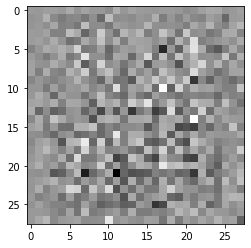

In [133]:
input_shape = 28
#num_color = 3
num_color = 1

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(num_color, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, num_color)

    return model

generator = make_generator_model()
generator.summary()


noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
#plt.imshow(generated_image[0, :, :, 0])

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=(input_shape, input_shape,num_color)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

discriminator.summary()

#### 32*32

In [ ]:
input_shape = 32
num_color = 1
#num_color = 3

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(num_color, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, num_color)

    return model


generator = make_generator_model()
generator.summary()


noise = tf.random.normal([5, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=(input_shape, input_shape,num_color)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

discriminator.summary()

### 64*64

In [ ]:
input_shape = 64
num_color = 3

noise_shape = 100


generator=tf.keras.Sequential()
generator.add(Dense(4*4*512,input_shape=[noise_shape]))
generator.add(Reshape([4,4,512]))
generator.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same",
                                 activation='sigmoid'))

generator.summary()


noise = tf.random.normal([5, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


discriminator= tf.keras.Sequential()
discriminator.add(Conv2D(32, kernel_size=4, strides=2, padding="same",input_shape=[64,64, 3]))
discriminator.add(Conv2D(64, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(BatchNormalization())
discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(BatchNormalization())
discriminator.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Flatten())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1,activation='sigmoid'))


discriminator.summary()

decision = discriminator(generated_image)
print (decision)



Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [134]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [135]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [136]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [137]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [138]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [139]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [140]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [141]:

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [142]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')   #for B$W images      #spring , 'gray')
    
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

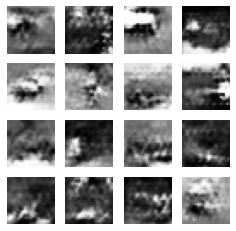

In [143]:
train(train_dataset, EPOCHS)

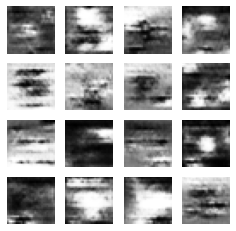

In [144]:
train(train_dataset, 100)

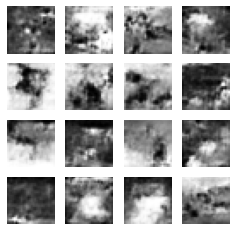

In [149]:
train(train_dataset, 100)

Restore the latest checkpoint.

In [150]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [151]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

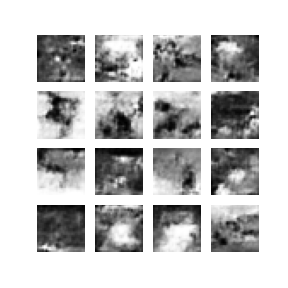

In [152]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [153]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)